# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.067701,True,4.668524
1,0.062282,True,4.955912
2,-1.663267,False,-2.663113
3,0.122808,True,5.518330
4,-0.027151,True,6.025264
...,...,...,...
995,-0.063197,True,3.936036
996,1.823367,True,7.378602
997,0.895647,True,7.131533
998,0.069219,True,5.462243


<AxesSubplot:xlabel='v0'>

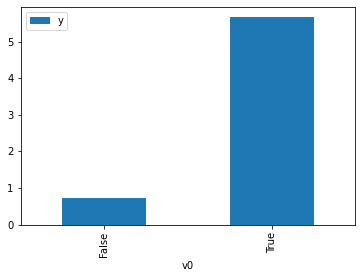

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

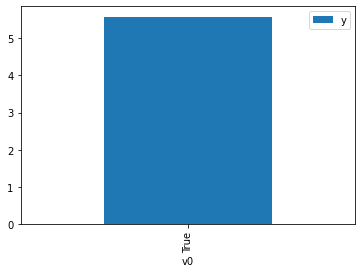

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.323372,False,-2.005205,0.616171,1.622925
1,-0.474952,False,-1.001151,0.676658,1.477852
2,1.012438,False,2.679224,0.134343,7.443609
3,0.745103,False,2.621244,0.198531,5.037001
4,1.417781,False,4.199004,0.070958,14.092775
...,...,...,...,...,...
995,0.161603,False,-0.132310,0.407352,2.454879
996,0.136962,False,-1.089818,0.417797,2.393507
997,0.268117,False,-1.161410,0.363265,2.752815
998,-1.210246,False,-1.209380,0.883349,1.132056


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.928112,True,9.068175,0.847561,1.179856
1,-0.353011,True,4.456920,0.371644,2.690746
2,1.160921,True,7.810720,0.893099,1.119697
3,0.279350,True,5.128045,0.641268,1.559411
4,0.521029,True,6.818470,0.731762,1.366564
...,...,...,...,...,...
995,-0.393867,True,4.231373,0.355115,2.815988
996,0.122808,True,5.518330,0.576170,1.735600
997,0.436431,True,7.415051,0.701744,1.425022
998,0.942143,True,8.007570,0.850705,1.175496


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.744e+04
Date:                Fri, 29 Jul 2022   Prob (F-statistic):                        0.00
Time:                        11:08:09   Log-Likelihood:                         -1379.9
No. Observations:                1000   AIC:                                      2764.
Df Residuals:                     998   BIC:                                      2774.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5996      0.036     71.728      0.000       2.528       2.671
x2             4.9921      0.047    105.401      0.000       4.899       5.085
==============================================================================
Omnibus:                        0.081   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.961   Jarque-Bera (JB):                0.146
Skew:                           0.003   Prob(JB):                        0.930
Kurtosis:                       2.941   Cond. No.                         1.96
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""